# HySwash: A hybrid method for nearshore wave processes

![sketch](./assets/hyswash-sketch.png)

## 1 Variable Sampling and Selection

It is essential to carefully select the variables that will feed into the presented metamodel. The numerical model SWASH (Simulating WAves till SHore) is designed to solve the Navier-Stokes equations numerically, relying on key hydrodynamic input variables. Drawing from previous research on hydrodynamic modeling, it has been proven that the necessary variables encompass:

- Significant wave height (Hs)
- Wave slope (Hs/L0)
- Water Level (WL)
- Vegetation Height (vegetation_height)
- Plants density (plants_density)


![profile](./assets/hyswash-profile.png)


The first step in implementing our metamodel involves generating and selecting specific representative cases that combine the variables previously identified. These combinations will accurately simulate realistic sea states in SWASH. Therefore, our task is to create realistic combinations of these variables to feed into the numerical model later on.

### Configure environment and create bathymetry

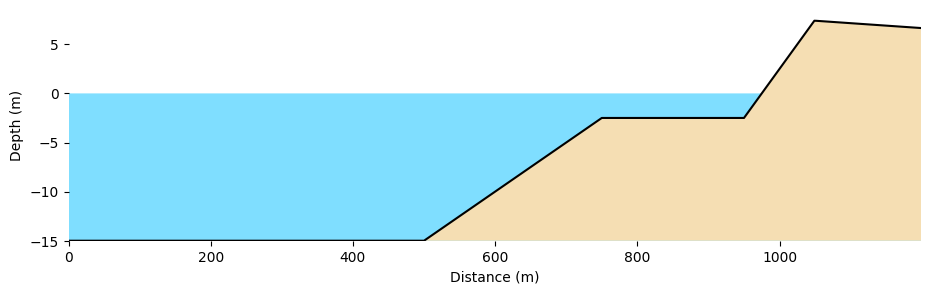

In [2]:
import os
import os.path as op
import numpy as np
import utils.plotting
import bluemath_tk.topo_bathy.profiles
from bluemath_tk.datamining.lhs import LHS
from bluemath_tk.datamining.mda import MDA
from bluemath_tk.waves.series import waves_dispersion 
from bluemath_tk.wrappers.swash.swash_wrapper import HySwashVeggyModelWrapper
from bluemath_tk.core.io import load_model
import xarray as xr

root_dir = os.getcwd()
#output_dir = "/lustre/geocean/DATA/hidronas1/valva/Veggy_topo_alba"
output_dir = os.path.join(root_dir, "output")
templates_dir = os.path.join(root_dir, "templates", "VeggyBig")
export_dir = op.join(root_dir, "HyVeggy_exported")

# Bathymetry parameters
h0 = 15               #offshore depth (m)
Slope1 = 0.05     #fore shore slope
Slope2 = 0.1       #inner shore slope
Wreef = 200       #reef bed width (m)
Wfore = 500       #flume length before fore toe (m)
bCrest = 10.          #beach heigh (m)
emsl = 2.5         #mean sea level (m)

#depth_array=bluemath_tk.topo_bathy.profiles.reef(1,20,1/20,1/20,300,500,5,2)
depth_array=bluemath_tk.topo_bathy.profiles.reef(1,h0,Slope1,Slope2,Wreef,Wfore,bCrest,emsl)
np.savetxt(os.path.join(templates_dir,"depth.bot"),depth_array)
utils.plotting.plot_depthfile(depthfile=op.join(templates_dir, "depth.bot"))

### 1.1. Latin Hypercube Sampling (LHS)

The Latin Hypercube Sampling (LHS) is a statistical technique designed to efficiently select parameter values across multiple dimensions while ensuring controlled randomness in the sampled data. To implement this technique, we start by establishing the limits for each variable.

In [3]:
variables_to_analyse_in_metamodel = ["Hs", "Hs_L0", "WL","vegetation_height","plants_density"]
lhs_parameters = {
    "num_dimensions": 5,
    "num_samples": 10000,
    "dimensions_names": variables_to_analyse_in_metamodel,
    "lower_bounds": [0.5, 0.005, 0, 0, 0],
    "upper_bounds": [2, 0.05, 1, 1.5, 1000],
}

lhs = LHS(
    num_dimensions=lhs_parameters.get("num_dimensions"),
)

lhs_dataset = lhs.generate(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
    num_samples=lhs_parameters.get("num_samples"),
)

# Calculation of the wave length and other parameters to avoid unphysical values
df_dataset_aux= lhs_dataset.copy()
df_dataset_aux['Tp'] = np.sqrt((df_dataset_aux['Hs'].values * 2 * np.pi) / (9.806 * df_dataset_aux['Hs_L0']))
df_dataset_aux['L'] = [waves_dispersion(i, h0)[0]  for i in df_dataset_aux['Tp']]
df_dataset_aux['h/L'] = (df_dataset_aux['WL'] + h0) / df_dataset_aux['L']
df_dataset_aux['kh'] = (2 * np.pi/df_dataset_aux['L']) * (df_dataset_aux['WL'] + h0)
df_dataset_aux = df_dataset_aux.loc[(df_dataset_aux['kh'] < 5) & (df_dataset_aux['Tp'] > 4)]
df_dataset_aux = df_dataset_aux.loc[(df_dataset_aux['h/L'] < 0.5)]
df_dataset=lhs_dataset.loc[df_dataset_aux.index]
df_dataset_aux


,Hs,Hs_L0,WL,vegetation_height,plants_density,Tp,L,h/L,kh
0,1.779423,0.027955,0.954886,1.308758,889.268817,6.386399,58.729617,0.271667,1.706933
1,0.833237,0.020341,0.825259,0.572768,969.397244,5.123173,40.235823,0.393313,2.471256
2,1.835037,0.043081,0.726167,0.091382,40.269681,5.224240,41.694165,0.377179,2.369886
4,1.401237,0.029614,0.145851,0.049203,503.103834,5.506216,45.810811,0.330617,2.077330
5,1.020991,0.020199,0.212572,0.775626,714.203007,5.691081,48.521641,0.313521,1.969913
...,...,...,...,...,...,...,...,...,...
9994,1.109684,0.016916,0.203825,0.931827,596.011296,6.483273,60.140084,0.252807,1.588432
9996,1.113801,0.034969,0.793745,0.341761,489.694169,4.517596,31.698235,0.498253,3.130617
9997,1.644109,0.034889,0.234881,0.751937,188.041985,5.494978,45.646174,0.333760,2.097078
9998,1.325042,0.036499,0.791658,0.442464,580.487684,4.823021,35.938626,0.439406,2.760871


### 1.2. Maximum Dissimilarity Algorithm (MDA)

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v_{1}}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.

,Hs,Hs_L0,WL,vegetation_height,plants_density
0,1.030526,0.025933,0.817371,0.921809,567.816359
1,1.910938,0.049842,0.014496,0.187277,31.440245
2,1.622246,0.007098,0.004179,0.028116,937.922218
3,1.885325,0.044034,0.117803,1.423387,980.337728
4,1.659696,0.011282,0.027849,1.365667,53.516565
...,...,...,...,...,...
995,1.620859,0.014786,0.906685,1.173581,413.884691
996,1.252494,0.007789,0.498807,0.567557,94.970851
997,1.261109,0.026004,0.932401,0.445693,686.617933
998,1.479866,0.028426,0.248067,0.050480,378.703969


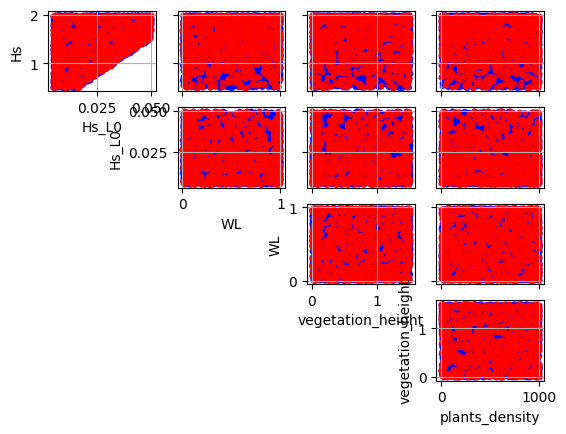

In [4]:
mda_parameters = {"num_centers": 1000}

mda = MDA(num_centers=mda_parameters.get("num_centers"))
mda.fit(data=df_dataset, first_centroid_seed=88,normalize_data=True)
mda.plot_selected_centroids()
mda.centroids



## 2. Numerical model SWASH

Once the hydrodynamic cases to be numerically simulated have been selected through the MDA algorithm, we proceed to launch these cases in SWASH. It is a versatile numerical tool designed to simulate a non-hydrostatic, phase-resolving wave model capable of simulating waves from deep waters to the shoreline, modeling wave breaking, bottom friction, wave- induced setup and runup, and the generation and propagation of infragravity waves (Delft University of Technology, n. d.).

In [11]:
os.environ["OMP_NUM_THREADS"] = "1"  
#from utils.ChySwash import ChySwashModelWrapper
from bluemath_tk.wrappers.swash.swash_wrapper import HySwashVeggyModelWrapper
import os.path as op

metamodel_parameters = mda.centroids.to_dict(orient="list")

fixed_parameters = {
    "dxinp": 1,         # bathymetry grid spacing  # Friction manning coefficient (m^-1/3 s)
    "Plants_ini": 750,  # Friction start cell
    "Plants_fin": 900, # Friction end cell
    "comptime": 7200,     # Simulation duration (s)
    "warmup": 7200*0.15,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60, # number of nodes per wavelength
}

swash_model = HySwashVeggyModelWrapper(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=np.loadtxt(op.join(templates_dir, "depth.bot")),
)

/software/geocean/conda/envs/bluemath_dev/lib/python3.13/importlib/__init__.py:129: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2025-05-16 14:20:35,639 - HySwashVeggyModelWrapper - WARNING - Parameter plants_density is not in the default_parameters


Save swash_model and mda to a pickle file

In [60]:
swash_model.save_model(
    model_path=op.join(export_dir, "swash_model.pkl")
)

mda._exclude_attributes=[]
mda.save_model(
    model_path=op.join(export_dir, "mda_model.pkl"),
)

In [12]:
swash_model.build_cases(cases_to_build=[0])

2025-05-16 14:20:40,339 - HySwashVeggyModelWrapper - WARNING - cases_to_build was specified, so just [0] will be built.


### Build, run and postprocess cases

In [ ]:
swash_model.build_cases(cases_to_build=0)
swash_model.run_cases()
swash_model.monitor_cases()

## 4. Data Processing

The primary output variable generated by SWASH include the time series of water level along the profile. This output serves as crucial indicator of the hydrodynamic processes impacting the reef. From this SWASH output, we compute various other key variables. Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. 

- To this end, the time-dependent surface elevation is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). 

- The run-up heigh is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. 

- The mean wave overtopping discharge q (ms/l) is outputted at the highest elevation point.

After each simulation, the postprocess steps creates 2 files in the directory of the case:
 
 - output.nc: It contains the case run.tab and output.tab in netCDF format.
 - output_postprocessed.nc: It contains the variables selected by the users. In our case: 'Ru2', 'Runlev', 'Msetup', 'Hrms', 'Hfreqs'.

The postprocessor also allows the creation of a single netCDF file with the postprocessed output of every case. It locates it in the output_dir.

In [79]:
swash_model.list_available_postprocess_vars()
postprocessed_output = swash_model.postprocess_cases()

ValueError: Cases context or cases directories are not set. Please run load_cases() first.

In [81]:
# Load postprocessed data from NetCDF File in case we do not want to postprocess again
postprocessed_output = xr.open_dataset(op.join(export_dir, "output_postprocessed.nc"))

Save the output of simulations that do not contains Nans in output_postprocess_clean.nc

In [34]:
ok=[]
for case_num in postprocessed_output.case_num.values:
    postprocessed_case = postprocessed_output.sel(case_num=case_num)
    #for var in postprocessed_case.data_vars:
    for var in ["Hrms"]:
        if postprocessed_case[var].isnull().values.any():
            # print the variable name and the first occurrence of NaN
            nan_indices = np.where(np.isnan(postprocessed_case[var].values))
        else:
            ok.append(case_num)
post_clean=postprocessed_output.copy(deep=True)
# get unique values of ok
post_clean=post_clean.sel(case_num=ok)
post_clean.to_netcdf(
    os.path.join(output_dir, "output_postprocessed_clean.nc")
)

In [80]:
postprocessed_clean = xr.open_dataset(op.join(output_dir, "output_postprocessed_clean.nc"))
mda=load_model(
    model_path=op.join(export_dir,"mda_model.pkl"),
)

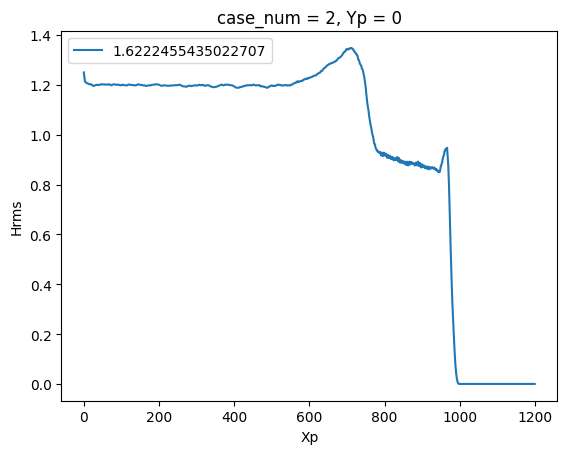

In [86]:
i=2
import matplotlib.pyplot as plt
postprocessed_output.isel(case_num=i)["Hrms"].plot(label=mda.centroids.Hs[i])
plt.legend()

### Numerical Cases Visualization

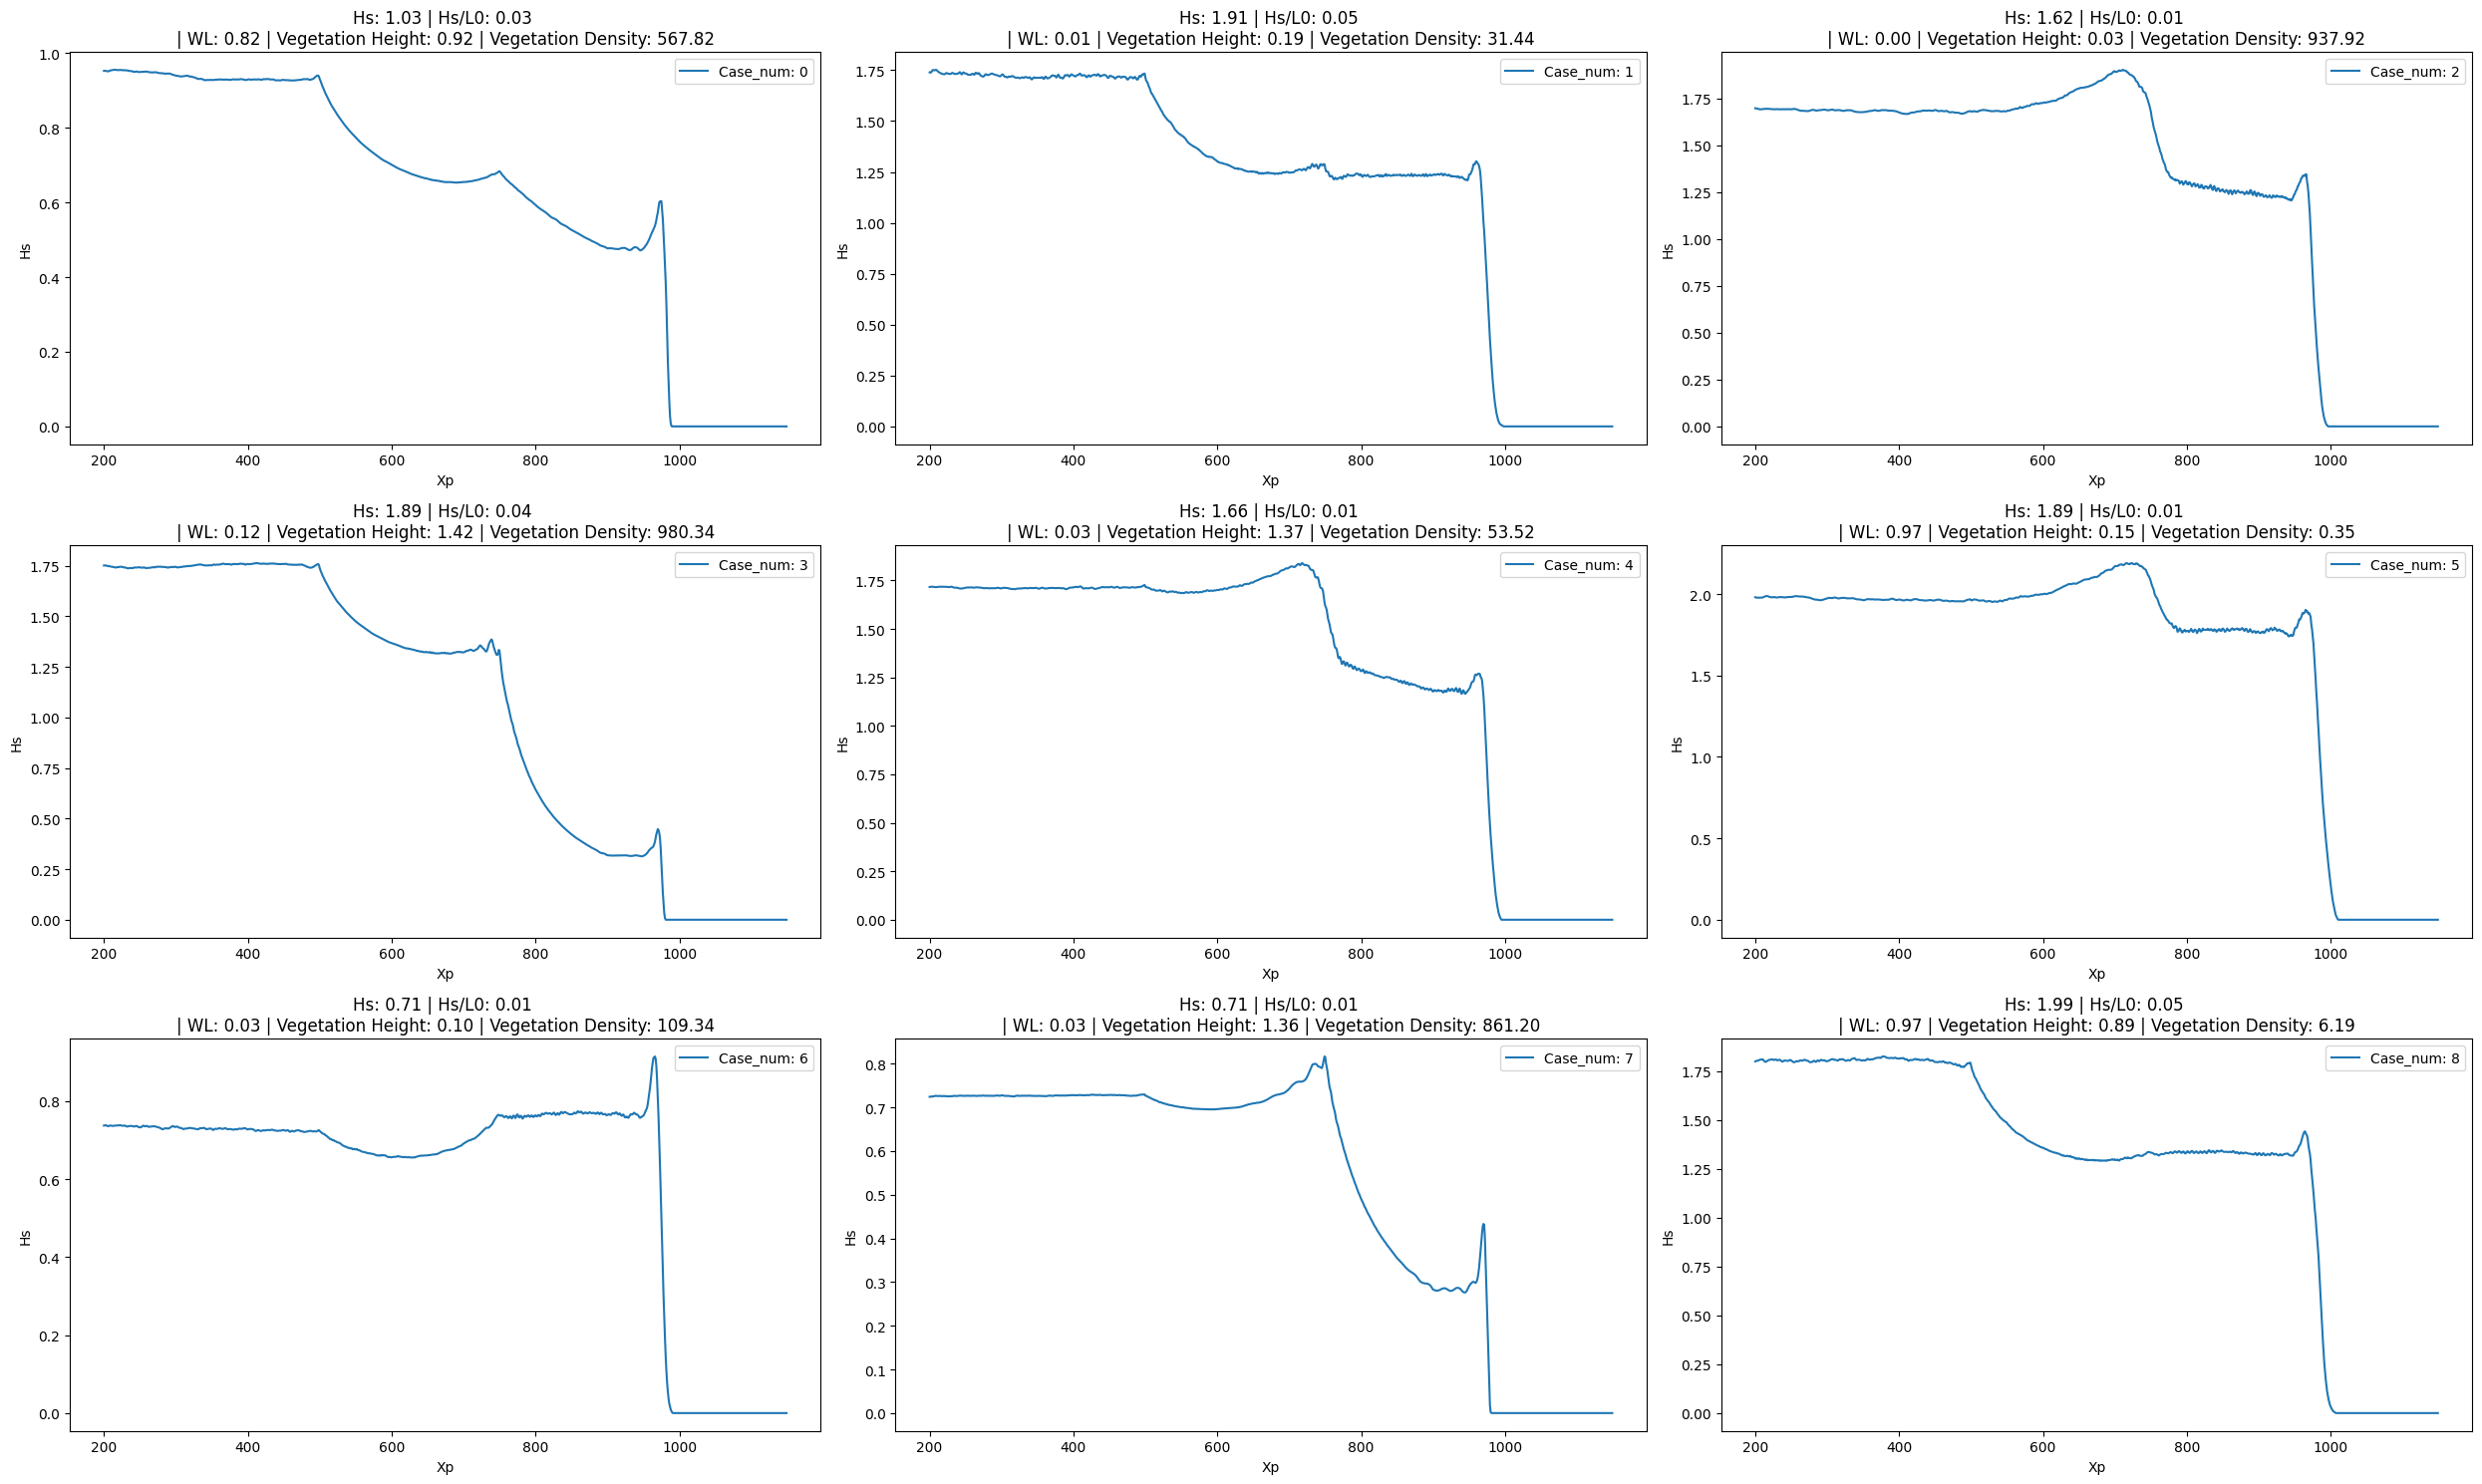

In [91]:
import matplotlib.pyplot as plt
n_rows = 3
n_cols = 3
fig, axes=plt.subplots(n_rows,n_cols,figsize=(25,15))
variable="Hs"
for case_num in np.arange(0,n_rows*n_cols):
    postprocessed_output.isel(case_num=case_num,Xp=slice(200, 1150))[variable].plot(ax=axes[case_num//n_cols,case_num%n_cols],label=f"Case_num: {case_num}")
    axes[case_num//n_cols,case_num%n_cols].set_title(f"Hs: {mda.centroids.Hs.values[int(case_num)]:.2f} | Hs/L0: {mda.centroids.Hs_L0.values[int(case_num)]:.2f} \n| WL: {mda.centroids.WL.values[int(case_num)]:.2f} | Vegetation Height: {mda.centroids.vegetation_height.values[int(case_num)]:.2f} | Vegetation Density: {mda.centroids.plants_density.values[int(case_num)]:.2f}")
    axes[case_num//n_cols,case_num%n_cols].legend()

plt.tight_layout()
fig.savefig("Hs.png")

### Total Water Elevation Visualization
Fill case_num with the number of the simulation you want to visualize



In [59]:
case_num = 0
case_num_s = str(case_num).zfill(4)

import xarray as xr
import numpy as np
from utils.plotting import animate_case_propagation
from IPython.display import HTML

depth = np.loadtxt(os.path.join(templates_dir, "depth.bot"))
output_nc=xr.open_dataset(op.join(output_dir, case_num_s, "output.nc"))
data=output_nc[["Watlev"]].squeeze()
#output_nc=xr.open_dataset("/lustre/geocean/DATA/hidronas1/Chy_cases/0000/output_postprocessed.nc")
ani = animate_case_propagation(
    data,
    depth,
    tini=0,
    tend=300,
    tstep=5,
    figsize=(10, 5),
)
HTML(ani.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


RunUp Scatter

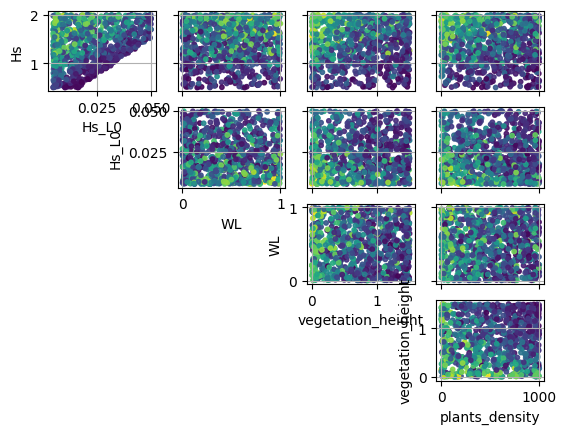

In [53]:
mda.centroids=mda.centroids.loc[postprocessed_clean.case_num.values]
# Add a column name Ru2 to the data with the value of Ru2
#postprocessed_clean.Ru2.values
fig,ax = mda.plot_selected_centroids(centroids_color=postprocessed_clean.Ru2.values,data_color="white")